In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
pip install -q keras

In [5]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.9MB/s 


In [7]:
import keras
import mtcnn
# print version
print(mtcnn.__version__)
print(keras.__version__)

0.1.0
2.4.3


In [8]:
#Load all necessary libraries
import numpy as np
import cv2 # opencv
import os 
from keras.models import Sequential,Model
from keras.layers import Convolution2D,Activation,Dense,MaxPooling2D,ZeroPadding2D,Flatten,BatchNormalization,Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.models import Model

In [13]:

# load the face dataset
data = np.load('/content/drive/My Drive/celebrity-faces-dataset.npz')
trainX, trainy= data['arr_0'], data['arr_1']
print('Loaded: ', trainX.shape, trainy.shape)

Loaded:  (733, 160, 160, 3) (733,)


In [45]:
# load the facenet model
facenet_model = load_model('/content/drive/My Drive/facenet_keras.h5')
print('Loaded Model')

Loaded Model


In [15]:
#getting Embedding using facenet model
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

(733, 128)


In [16]:
#encoding categorical variable
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
trainy_enc = lb.fit_transform(trainy)

In [17]:
#train and vaalidation data split
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val= train_test_split(emdTrainX,trainy_enc)

Using classifier algorithms to make prediction

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(X_train)
emdTestX_norm = in_encoder.transform(X_val)
# label encode targets
# fit model
#model =SVC(kernel='linear', probability=True)
#model= RandomForestClassifier(max_depth=100)
#model=GradientBoostingClassifier()
#model= XGBClassifier()
seed = 7
#cart = DecisionTreeClassifier()
num_trees =  400
#model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
#model = ExtraTreesClassifier(n_estimators=num_trees)
#estimators = []
#model1 =GradientBoostingClassifier()
#estimators.append(('logistic', model1))
#model2 = RandomForestClassifier()
#model=GradientBoostingClassifier
#estimators.append(('cart', model2))
model = SVC(kernel='linear', probability=True)
#estimators.append(('svm', model3))
# create the ensemble model
#model = VotingClassifier(estimators,voting='soft')
#model= DecisionTreeClassifier()
model.fit(emdTrainX_norm, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [23]:
#testing on training and test set
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(Y_train, yhat_train)
score_test = accuracy_score(Y_val,yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=99.457


In [30]:
#function to extract image
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    for i in range(0,len(results)):
      x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
       # extract the face
      face = pixels[y1:y2, x1:x2]
       # resize pixels to the model size
      image = Image.fromarray(face)
      image = image.resize(required_size)
      face_array = np.asarray(image)

      return face_array

In [44]:
#function to make predictions
def prediction(path):

  pixels = extract_face(path)
  print(pixels.shape)  

  img = get_embedding(facenet_model, pixels)
  samples = np.expand_dims(img, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
# get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = lb.inverse_transform(yhat_class)
  
  o_img = cv2.imread(path)
  plt.imshow(o_img) # display all images read
  plt.xticks([]), plt.yticks([])
  title = '%s (%.3f)' % (predict_names, class_probability)
  plt.title(title)
  plt.show()

## PROOF Testing 
give your image path and find out your prediction

(160, 160, 3)


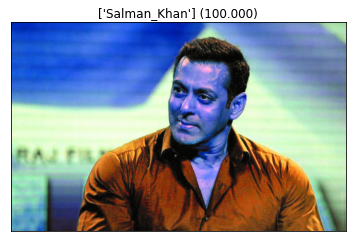

In [41]:
predict = prediction("/content/drive/My Drive/file733arr7okwz16s65tngw-1553159893.jpg")

(160, 160, 3)


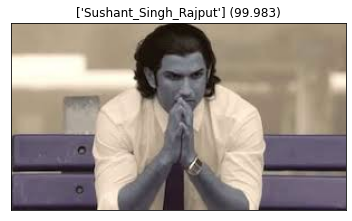

In [43]:
predict = prediction("/content/drive/My Drive/images (4).jpg")